# Bin migration

In [15]:
%reset -f

import ROOT, json

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(16)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetPadRightMargin(0)
ROOT.gStyle.SetPadBottomMargin(0.12)
ROOT.gStyle.SetPadLeftMargin(0.07)
ROOT.gStyle.SetTitleOffset(0.7, 'Y')
ROOT.gStyle.SetTitleSize(0.06,'T')
ROOT.gStyle.SetTitleSize(0.05,'xy')
ROOT.gStyle.SetLabelSize(0.043,'xy')

ROOT.TH1.AddDirectory(0)

%run -i eppi0_columns.py
%run -i eppi0_genvals.py
%run -i eppi0_binning_scheme_v3.py

jcounts = []
for fname in ['data/lvl2_eppi0.inb.mc.aaorad.smear.root', 'data/lvl2_eppi0.outb.mc.aaorad.smear.root']:
    cnts = {}
    df = ROOT.RDataFrame("h22", fname)
    df = define_true_eppi0_columns(df)
    if 'mc' in fname:
        df = df.Define("ihel","1")
    df = define_eppi0_columns_using_proton(df)
    df = define_eppi0_bins(df, fname)
    df = df.Filter("abs(dpt)<0.3 && abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4")
    df = df.Filter("&&".join(f"(((int)status)&(1<<{i}))" for i in [gloosest,prodc]))
    df = df.Filter("thp<44.106+-6.625*pp+1.438*pp*pp")
    for iqx in range(5):
        for iqx0 in range(5):
            for imt in range(3):
                for imt0 in range(3):
                    kk = str((iqx,imt,iqx0,imt0))
                    cnts[kk] = df.Filter(f"iqx=={iqx} && iqx0=={iqx0} && itt=={imt} && imt0=={imt0}").Count()
    for kk in cnts:
        cnts[kk] = cnts[kk].GetValue()
    jcounts.append(cnts)

with open("bin_migration.json", 'w') as ff:
    json.dump(jcounts, ff)

In [16]:
with open('bin_migration.json') as ff:
    jcounts = json.load(ff)

counts = []
for jcnts in jcounts:
    counts.append({}) 
    for kk in jcnts:
        counts[-1][eval(kk)] = jcnts[kk]
    

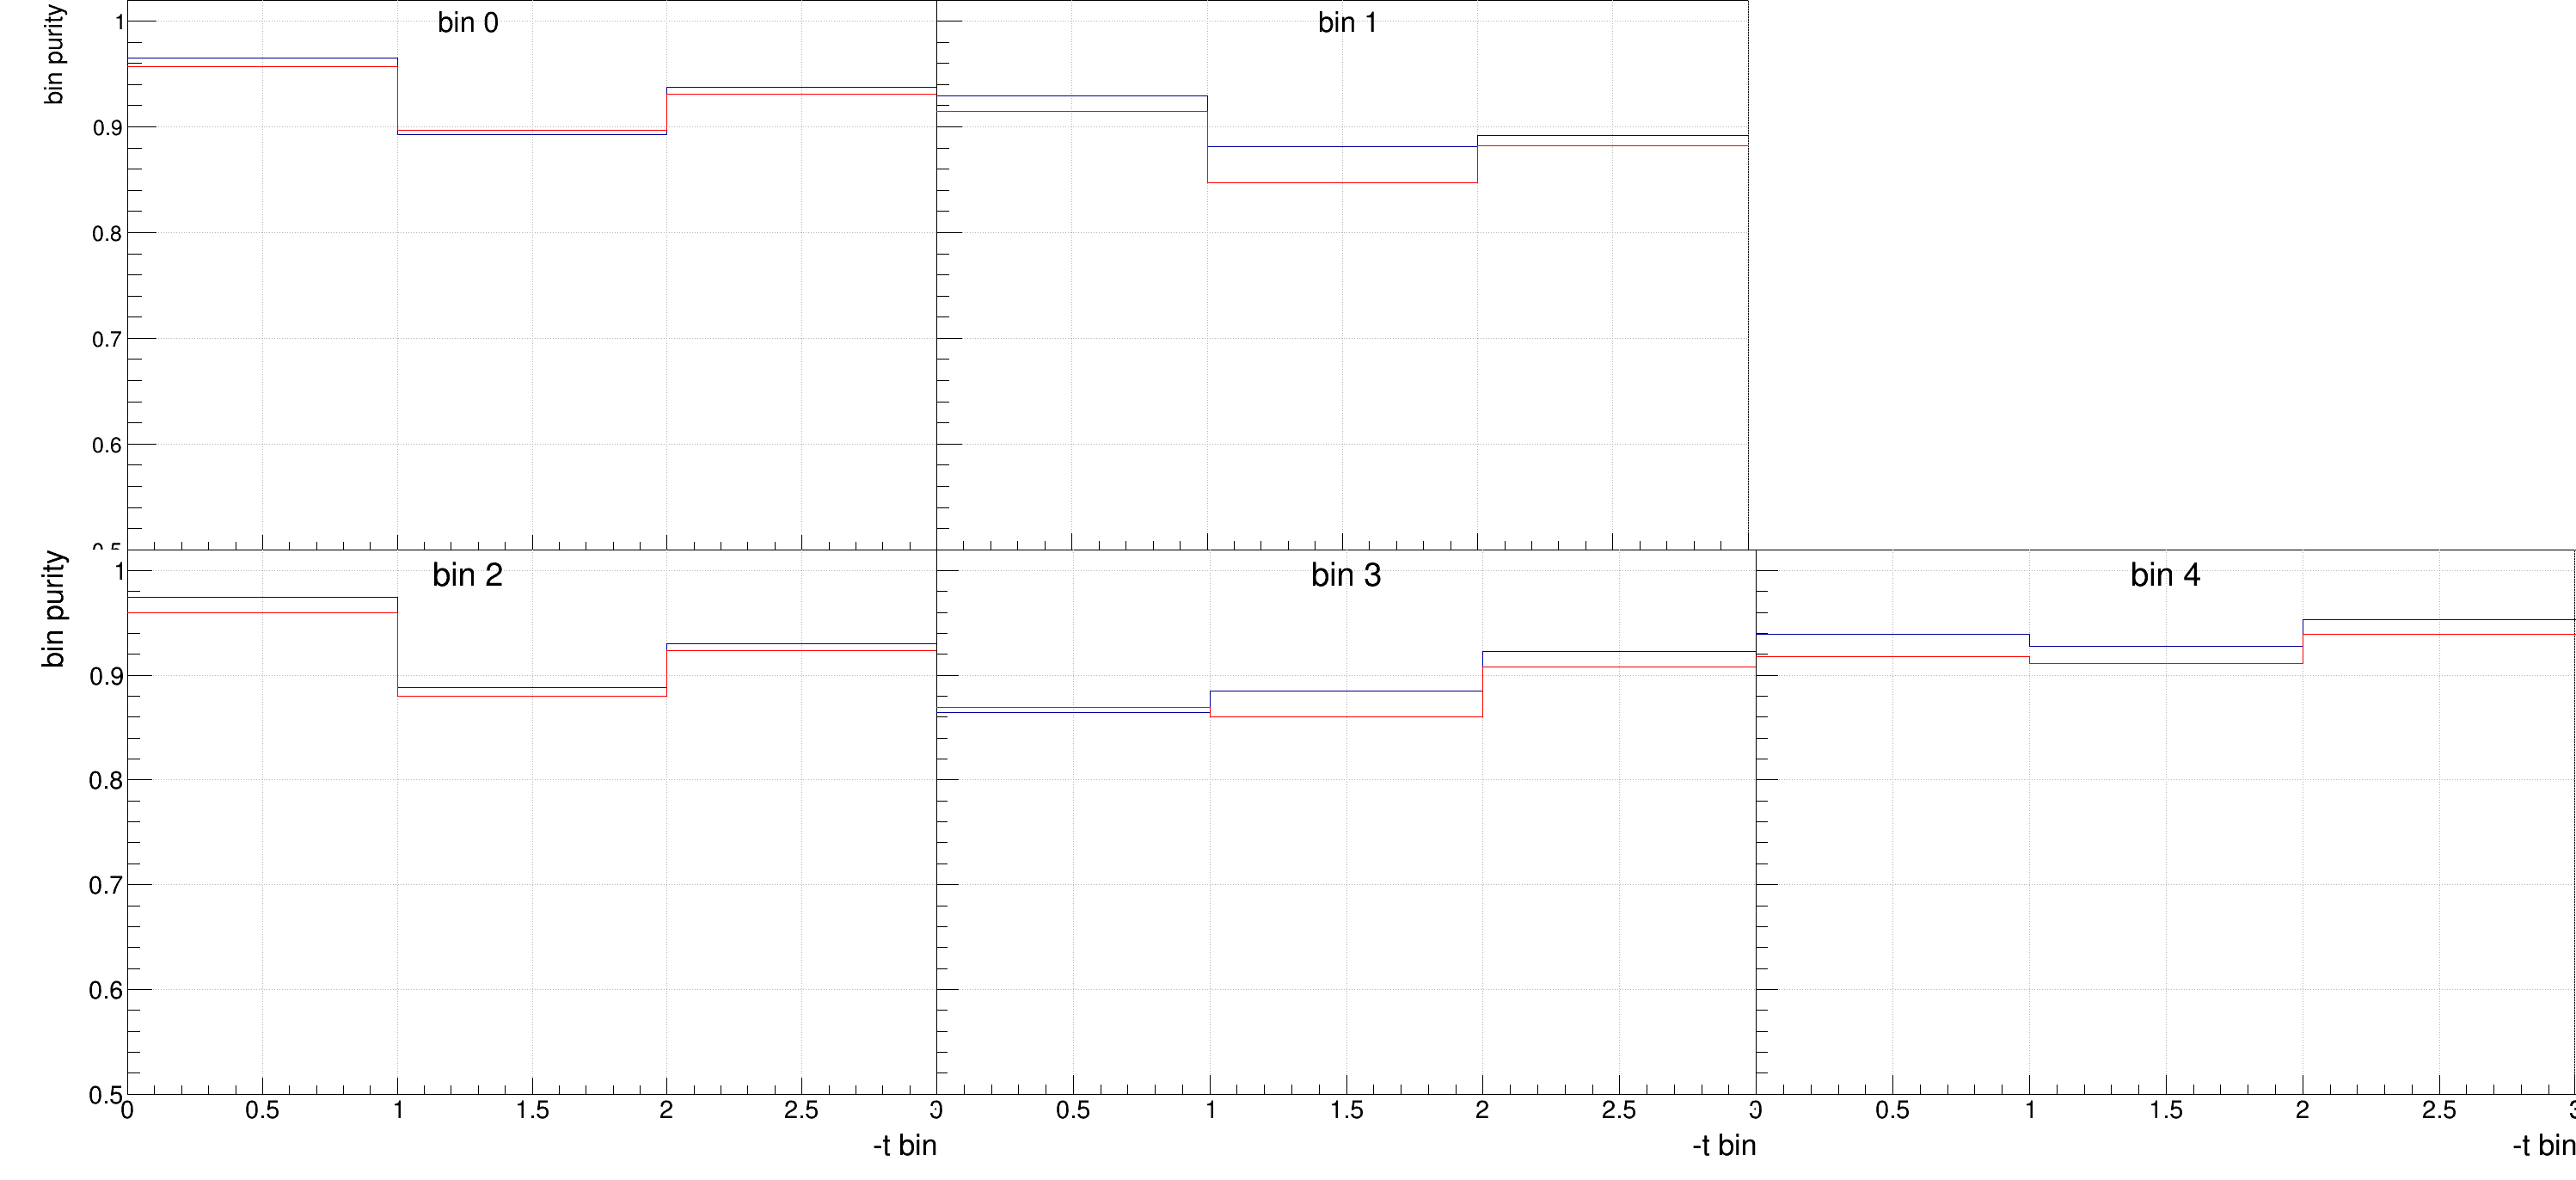

In [17]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)


c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []

ipad=0
for iqx in range(5):
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.01)
    hh = c1.cd(ipad).DrawFrame(0,0.5,3,1.02)
    hh.SetTitle(f"bin {iqx};-t bin;bin purity")

    h0 = ROOT.TH1F("hpure0",";-t bin;bin purity",3, 0,3)
    h1 = ROOT.TH1F("hpure1",";-t bin;bin purity",3, 0,3)
    h1.SetLineColor(2)
    
    for itt in range(3):
        cnts = counts[0]
        purity = cnts[(iqx,itt,iqx,itt)]/sum(cnts[kk] for kk in cnts if kk[2]==iqx and kk[3]==itt)
        h0.Fill(itt, purity)
        cnts = counts[1]
        purity = cnts[(iqx,itt,iqx,itt)]/sum(cnts[kk] for kk in cnts if kk[2]==iqx and kk[3]==itt)
        h1.Fill(itt, purity)

    h0.Draw("same hist")
    h1.Draw("same hist")
    grs.append((h0,h1))

c1.Print("pdf/purity.pdf")

________________________________
________________________________
________________________________